In [2]:
%matplotlib notebook
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import os
import math

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from NLPcleansing import prep
from customRNNgraph import RNN_build_graph
from customRNNgraphBidrection import RNN_bidirect_build_graph

In [3]:
MAX_NB_WORDS = 200000
MAX_SEQUENCE_LENGTH = 18
FORWARD_STEPS = 1
BATCH_SIZE = 32
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.1

num_epochs = 20
num_hidden = 100

In [4]:
# read data from twitter
tweet_data   = pd.read_csv('datasets/us_airline.csv')
columns = ['text', 'airline_sentiment']
tweet_data_extract = tweet_data[:][columns]
tweet_data_extract.dropna()
tweet_data_extract["clean_text"] = tweet_data_extract["text"].map(lambda x: prep.text_to_wordlist(x))
tweet_data_extract["labels"] = tweet_data_extract["airline_sentiment"].map(lambda x: prep.sentiment_to_label(x, ['neutral', 'positive', 'negative']))
print('Found %s tweets' % len(tweet_data_extract["clean_text"]))

Found 14640 tweets


In [5]:
# tokenize tweets
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(tweet_data_extract["clean_text"])
sequence_tweets = tokenizer.texts_to_sequences(tweet_data_extract["clean_text"])
sequence_tweets_pad = pad_sequences(sequence_tweets, MAX_SEQUENCE_LENGTH)
word_index = tokenizer.word_index
print('Found %s tokens' % len(word_index))

Found 15074 tokens


In [6]:
if os.path.isfile('embedding_matrix.npy'):
    embedding_matrix = np.load("embedding_matrix.npy")
else:
    GloVe_file = "datasets/glove.6B/glove.6B.300d.txt"
    word2vec_file = "datasets/glove_word2vec.txt"
    embedding_matrix = prep.word2vec_GloVe(GloVe_file, word2vec_file, word_index=word_index)
    np.save("embedding_matrix.npy", embedding_matrix)
nb_words = embedding_matrix.shape[0]

In [7]:
train_seq = sequence_tweets_pad
label_seq = tweet_data_extract["labels"]
np_train_seq = np.array(list(train_seq), dtype='int32')
np_label_seq = np.array(list(label_seq), dtype='int32')

########################################
## sample train/validation data
########################################
np.random.seed(1234)
perm = np.random.permutation(len(np_train_seq))
idx_train = perm[:int(len(np_train_seq)*(1-VALIDATION_SPLIT))]
idx_val = perm[int(len(np_train_seq)*(1-VALIDATION_SPLIT)):]

data_train = np_train_seq[idx_train]
data_val = np_train_seq[idx_val]

labels_train = np_label_seq[idx_train]
labels_val = np_label_seq[idx_val]

print('dtype of train data: %s' % data_train.dtype)
print('dtype of train label: %s' % labels_train.dtype)

print('shape of train data: ', data_train.shape)
print('shape of train label: ', labels_train.shape)

dtype of train data: int32
dtype of train label: int32
shape of train data:  (13176, 18)
shape of train label:  (13176,)


In [8]:
steps_per_train_epoch = int(data_train.shape[0]/BATCH_SIZE)+1
steps_per_valid_epoch = int(data_val.shape[0]/BATCH_SIZE)+1
print('TRIAN STEP %d' % steps_per_train_epoch)
print('VALID STEP %d' % steps_per_valid_epoch)

data = {'train_data': data_train, 'train_labels': labels_train, 'embedding': embedding_matrix, 
        'test_data': data_val, 'test_labels': labels_val}

TRIAN STEP 412
VALID STEP 46


In [ ]:
inital_scalar = np.array([7.01,218.24,1.52,163.68,53.29,763.83,1,76.38])
ratio = np.size(inital_scalar)/inital_scalar.sum()
label_weight = np.diag(ratio*inital_scalar)

In [ ]:
g_bidirect_retask = RNN_bidirect_build_graph(state_size = EMBEDDING_DIM,
                                      num_words = nb_words, 
                                      num_classes = 3, 
                                      batch_size = BATCH_SIZE,
                                      sequence_length = MAX_SEQUENCE_LENGTH,
                                      cell_type = 'LN_LSTM',
                                      num_layers = 3,
                                      init_trainable = False)
pretrain_model = "models/bidirect_lstm/base_bidirect/LN_LSTM_bidirect_word_prediction.ckpt"
save = "models/bidirect_lstm/retask_bidirect/LN_LSTM_bidirect_sentiment.ckpt"
t = time.time()
losses = g_bidirect_retask.train_finetune_model(data, num_epochs=500, dropout=0.8, save = save, pretrain_model = pretrain_model, verbose_graph=True, label_weight=label_weight)
print("It took", time.time() - t, "seconds to train for 455 epochs.")
print("The average loss on the final epoch was:", losses['training_losses'][-1])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Loading Model ...
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/bidirect_lstm/finetune_bidirect/LN_LSTM_bidirect_sentiment.ckpt
Pre-trained Model Loaded
training start ...


<IPython.core.display.Javascript object>


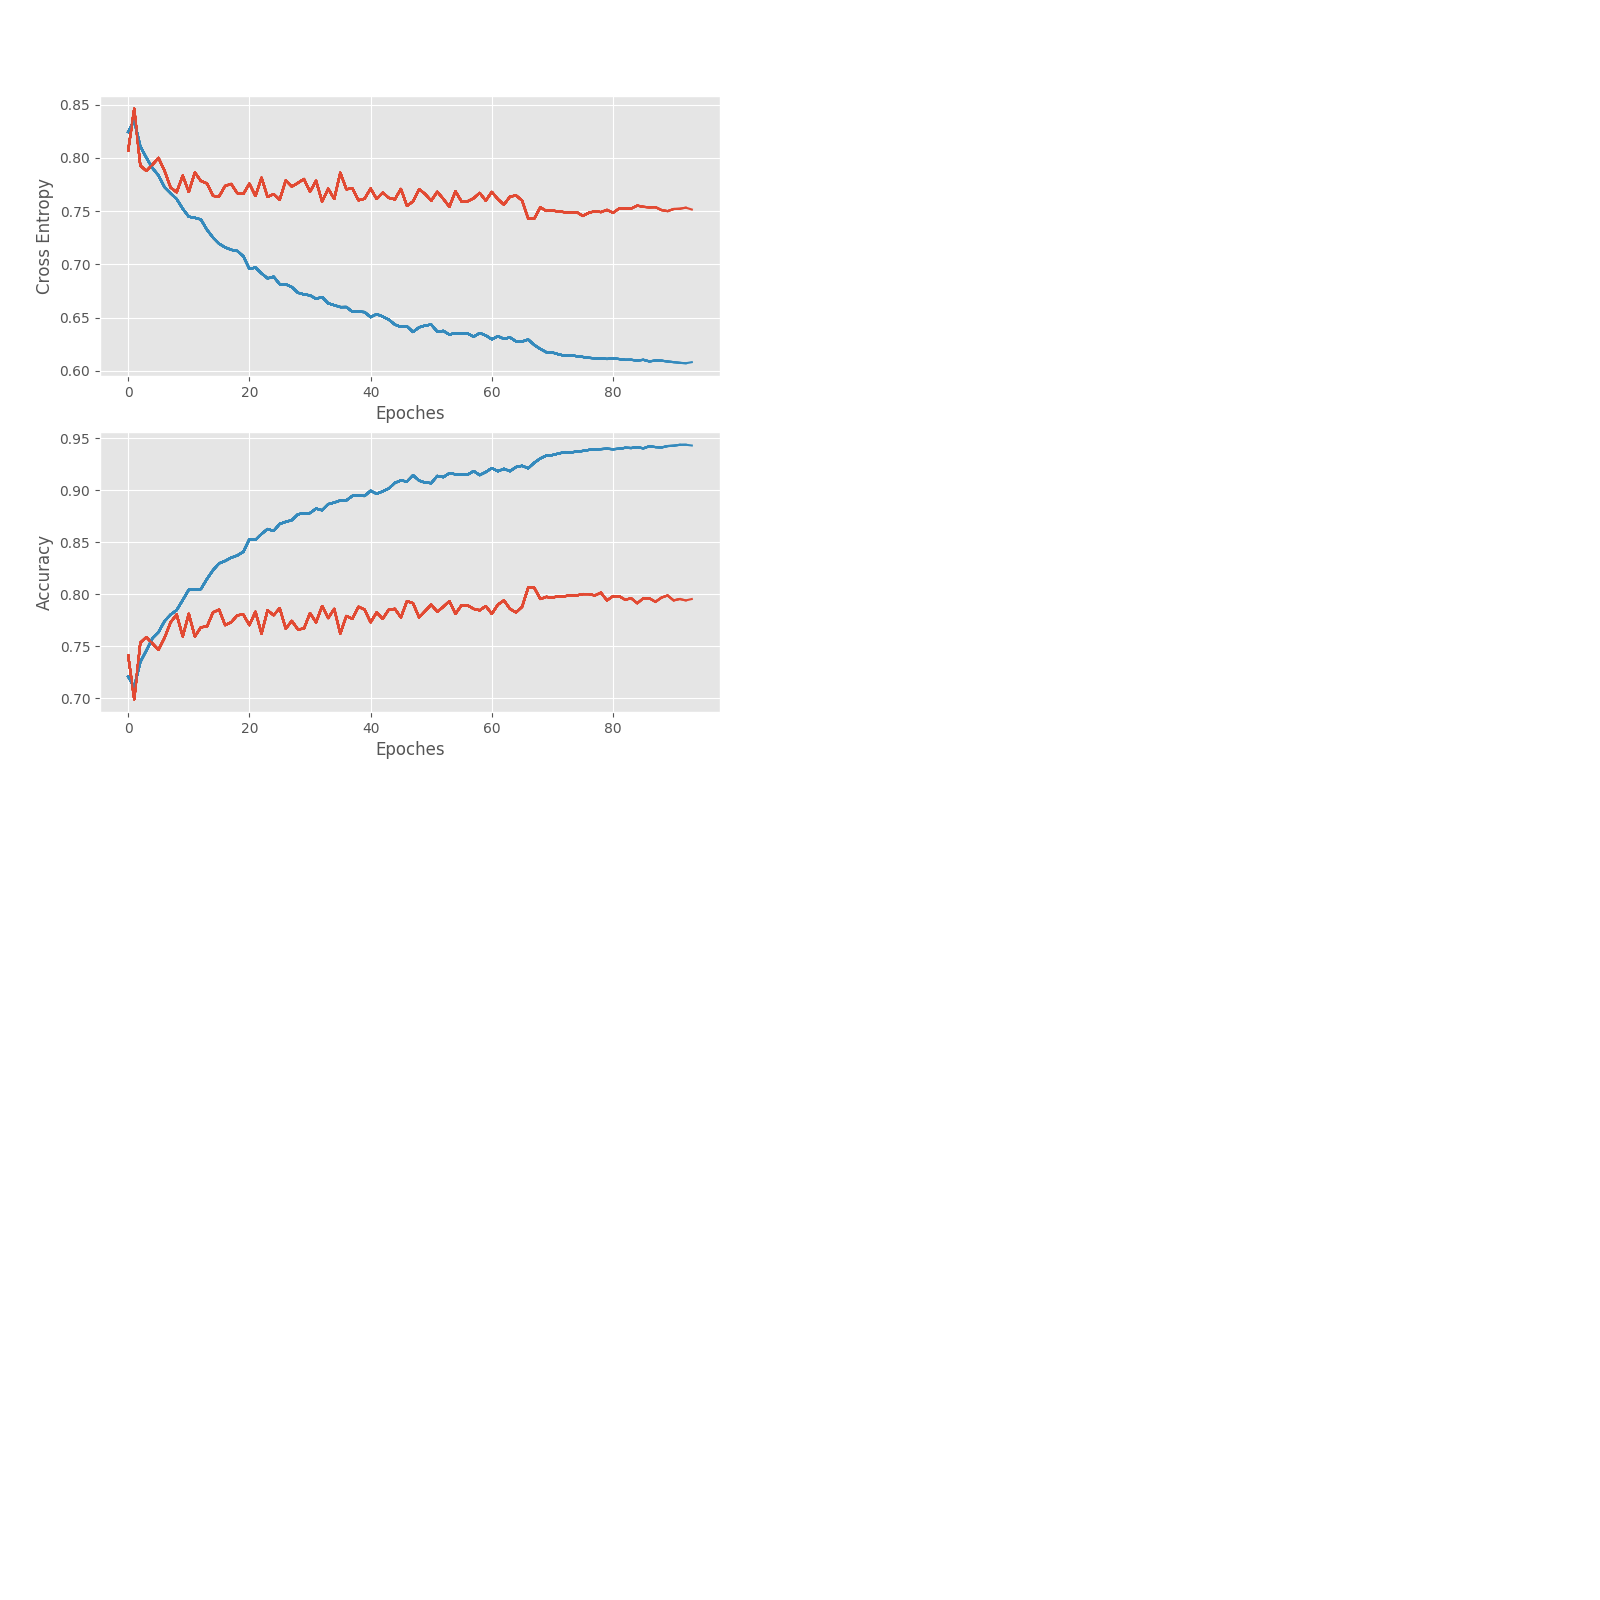

RNN Layer Freeze:  DISENGAGE 
Average training loss for Epoch 0 : 0.620619140927074  | Average training accuracy: 0.9307493932038835
Average  testing loss for Epoch 0 : 0.7534795260947683  | Average testing accuracy: 0.795516304347826
Average training loss for Epoch 1 : 0.6175593863991857  | Average training accuracy: 0.9335558252427184
Average  testing loss for Epoch 1 : 0.7502488519834436  | Average testing accuracy: 0.7975543478260869
Average training loss for Epoch 2 : 0.6172714982796641  | Average training accuracy: 0.9340109223300971
Average  testing loss for Epoch 2 : 0.7504953586536905  | Average testing accuracy: 0.796875
Average training loss for Epoch 3 : 0.6156058736796518  | Average training accuracy: 0.9354520631067961
Average  testing loss for Epoch 3 : 0.7497179974680361  | Average testing accuracy: 0.798233695652174
Average training loss for Epoch 4 : 0.6142870328090724  | Average training accuracy: 0.936817354368932
Average  testing loss for Epoch 4 : 0.74904072284698

KeyboardInterrupt: 

In [9]:
g_bidirect_finetune = RNN_bidirect_build_graph(state_size = EMBEDDING_DIM,
                                      num_words = nb_words, 
                                      num_classes = 3, 
                                      batch_size = BATCH_SIZE,
                                      sequence_length = MAX_SEQUENCE_LENGTH,
                                      cell_type = 'LN_LSTM',
                                      num_layers = 3,
                                      init_trainable = False)
#pretrain_model = "models/bidirect_lstm/retask_bidirect/LN_LSTM_bidirect_sentiment.ckpt"
pretrain_model = "models/bidirect_lstm/finetune_bidirect/LN_LSTM_bidirect_sentiment.ckpt"
save = "models/bidirect_lstm/finetune_bidirect/LN_LSTM_bidirect_sentiment.ckpt"
t = time.time()
losses = g_bidirect_finetune.train_finetune_model(data, num_epochs2=100, learning_rate2 = 1e-5, dropout2 = 0.8, save = save, pretrain_model = pretrain_model, verbose_graph=True, training_resume=True, label_weight=label_weight)
print("It took", time.time() - t, "seconds to train for 40 epochs.")
print("The average loss on the final epoch was:", losses['training_losses'][-1])